# Time Series Analysis
## Recovering A Stochastic Signal 

* By Daniel Cuneo

This is a pretty basic example of how to filter and recover a random signal from a time series that that has a linear combination of confounding noise.

This notebook has done through several iterations as I learned more about Boostrapping, Jackknifing and KDE. My signal processing here is pretty solid, however you may want to take the statistical examples with a grain of salt. Ultimately, it's probably best to use a cross validation for any statistic that is important. I work on that in a separate notebook in the near future.

In [346]:
#%install_ext https://raw.githubusercontent.com/rasbt/watermark/master/watermark.py
%reload_ext watermark
%watermark -p numpy,scipy,pandas,matplotlib


numpy 1.10.1
scipy 0.16.0
pandas 0.16.2
matplotlib 1.4.0


In [347]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as signal
%matplotlib inline

In [348]:
df = pd.read_csv("/home/daniel/git/Python2.7/DataScience/notebooks/TimeSeries/data.csv")

In [349]:
df.head()

,date,day.of.week,car.count,weather
0,2010-01-01,friday,94.5,-0.1
1,2010-01-02,saturday,108.4,-2.4
2,2010-01-03,sunday,105.5,-0.5
3,2010-01-04,monday,109.6,-2.1
4,2010-01-05,tuesday,116.1,1.9


In [350]:
# I like using Pandas b/c of the datetime features, resample or groupby
df['date'] = pd.to_datetime(df['date'])
df.set_index(df['date'], inplace=True)

## Initial Plot

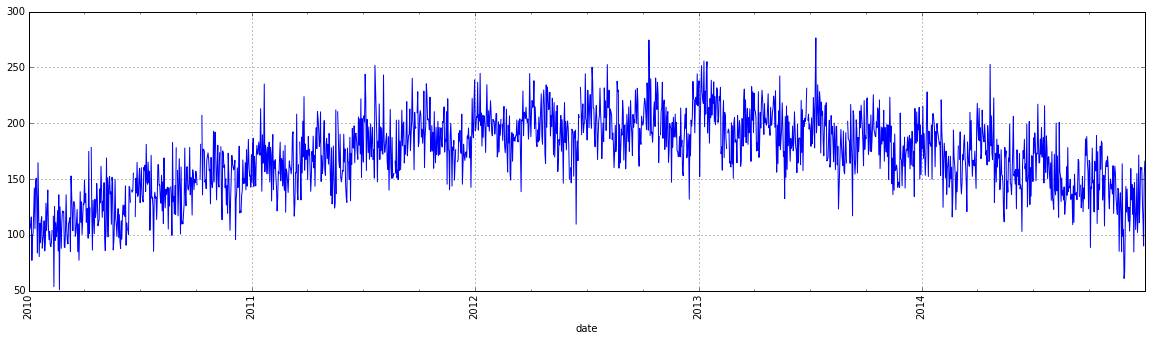

In [351]:
df['car.count'].plot(rot=90, figsize=(20, 5), grid=True);

I'd guess that we have a linear combination of a quadratic, sinusoid and random stochastic signal.


### Single Year Analysis: first year in the record

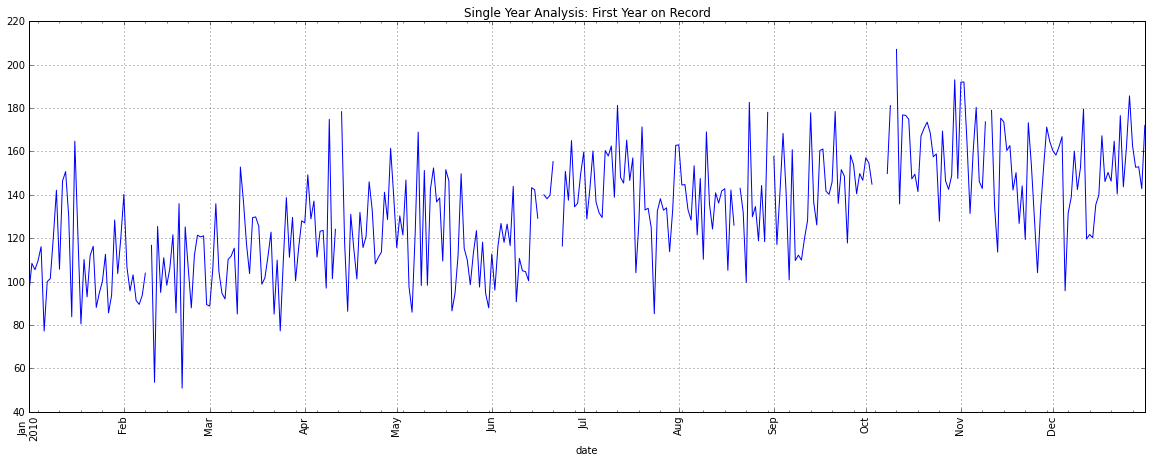

In [352]:
# year = df['car.count'][0:365]  if you are in a rush
year = df[df['date'] < pd.to_datetime('20110101')]['car.count']
year.plot(rot=90, figsize=(20, 7), grid=True, title="Single Year Analysis: First Year on Record");

It's not easy to see, but there are missing values in the series. We need to treat those.

In [353]:
#TODO: add to signal processing module

def remove_nans(data, return_nan_index=False):
    nan_ind = np.nonzero(~np.isfinite(data))[0]
    good_data_ind = np.nonzero(np.isfinite(data))[0]
    good_data = data[good_data_ind]
          
    new_points = np.interp(nan_ind, good_data_ind, good_data)
    data[nan_ind] = new_points
    
    if return_nan_index:
        return data, nan_ind
    else:
        return data

In [354]:
year, nan_ind = remove_nans(year.copy(), return_nan_index=True)
year_linear_det = signal.detrend(year, axis=0, type='linear')

Single Year Linear Detrend Time Series

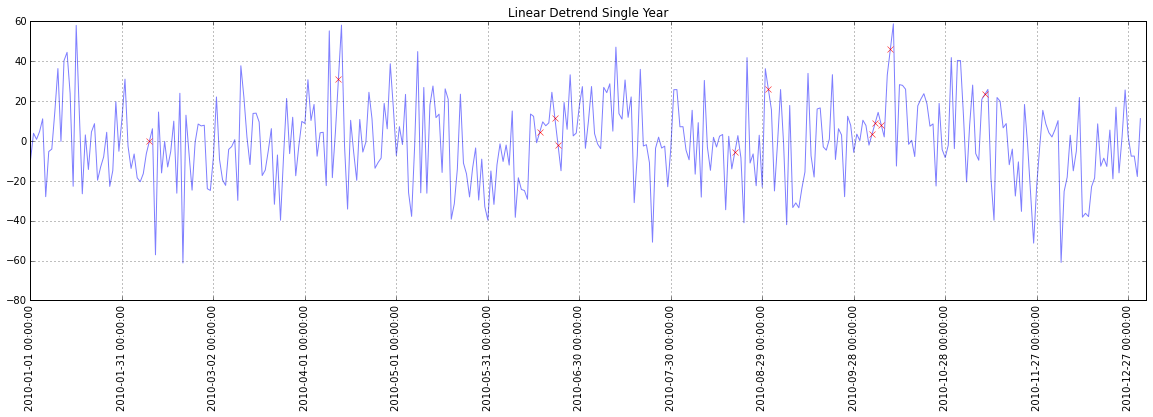

In [355]:
plt.figure(figsize=(20, 5))
plt.xticks(np.arange(year.shape[0])[0::30], year.index[0::30], rotation=90)
plt.plot(year_linear_det, alpha=0.5)
plt.title("Linear Detrend Single Year")
plt.plot(nan_ind, year_linear_det[nan_ind], 'rx')
plt.xlim(0, 366)
plt.grid()

We see a $\approx$ 90 day period here.

Without more insight about the data we don't know if this is a nuisance or
a feature we are looking for.

The NaN replacements look reasonable.

A group-by is sort of like a Fourier Transform where we choose just one frequency bin. There's the sinusodial period $\approx$ 90 days.

## Removing Confounds
### Quadratic Detrend Using PolyFit

In [356]:
poly =  np.polynomial.polynomial             
counts = remove_nans(df['car.count'].copy(), return_nan_index=False)

t = np.arange(df.shape[0])
coefs = poly.polyfit(t, counts, deg=2, full=False)
fit_curve = poly.polyval(t, coefs)

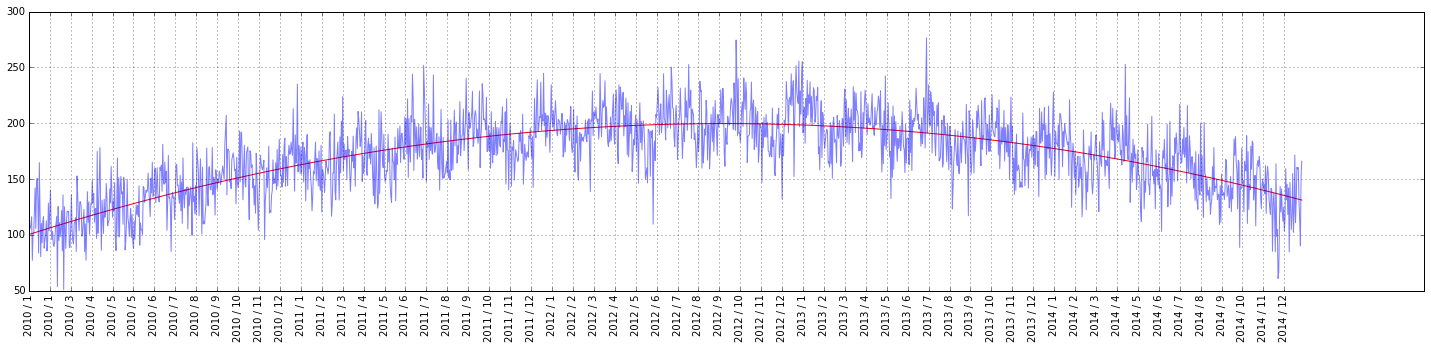

In [357]:
plt.figure(figsize=(25, 5))

plt.plot(fit_curve, 'r')
plt.plot(t, counts, alpha=0.5)
plt.grid()

labels = df['date']
date_str = map(lambda x: str(x.year) + " / "  + str(x.month), labels)
plt.xticks(t[0::30], date_str[0::30], rotation="vertical");

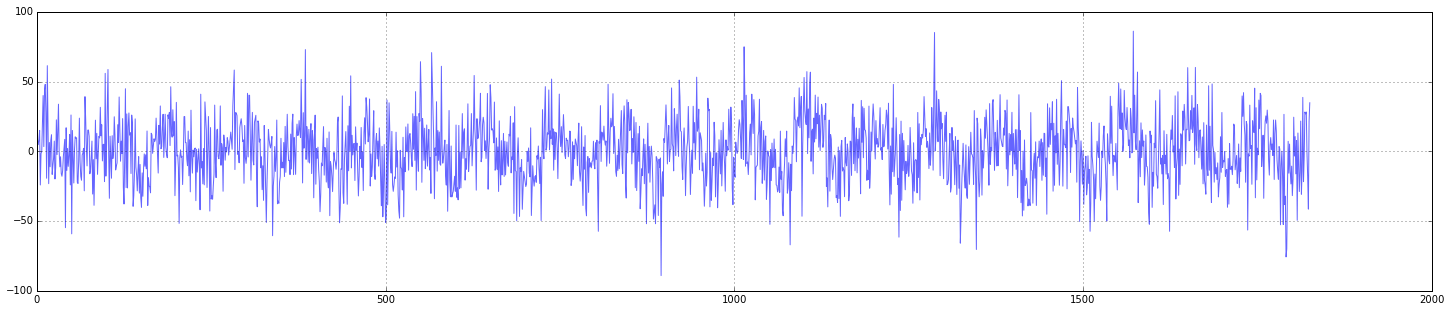

In [358]:
det_curve = counts - fit_curve
plt.figure(figsize=(25, 5))
plt.plot(det_curve, alpha=0.6);
plt.grid()

## Further Confound Removal
Lets suppose that the quadratic is a measurement error and that the $\approx$ 90 day sinusodial is a well understood or nuisance, then we'll examine the remainder of the signal.

In [359]:
import sys
sys.path.append("/home/daniel/git/Python2.7/MRI/Modules")
import SignalProcessTools

sigtools = SignalProcessTools.SignalProcessTools()

### Frequency Domain Analysis Using FFT
I keep this method handy and it should be in my Sigtools Module. It's just as well that you can see inside the Welch call.

In [360]:
def fft(data):
        '''Plot FFT using Welch's method'''
        f, y = signal.welch(data, fs=1.0, nperseg=128, noverlap=64, nfft=512, scaling='spectrum', detrend="linear")
        
        interval = 3 # days
        periods = np.round(1./f[0::interval], 1)
        # clean up frequency of 0 Hz
        periods[0] = 0 # avoid 1/ 0 
        
        frqs = f[0::interval]
        plt.xticks(frqs, periods, rotation="vertical")
        
        plt.plot(f, y)
        #plt.semilogy(f, y)
        
        plt.grid(True) 
        plt.ylabel("Relative ratio of spectrum")
        plt.xlabel("Number of days in a period")
               
        return f, y, frqs

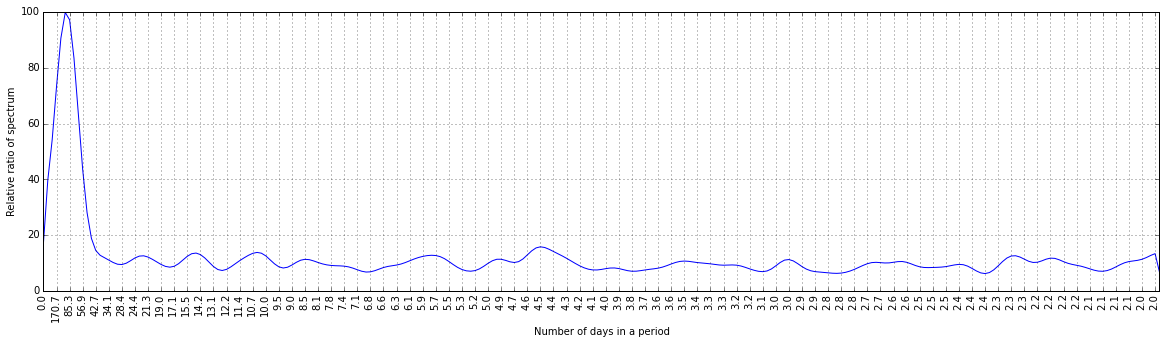

In [361]:
plt.figure(figsize=(20, 5))
f, y, frqs = fft(det_curve)

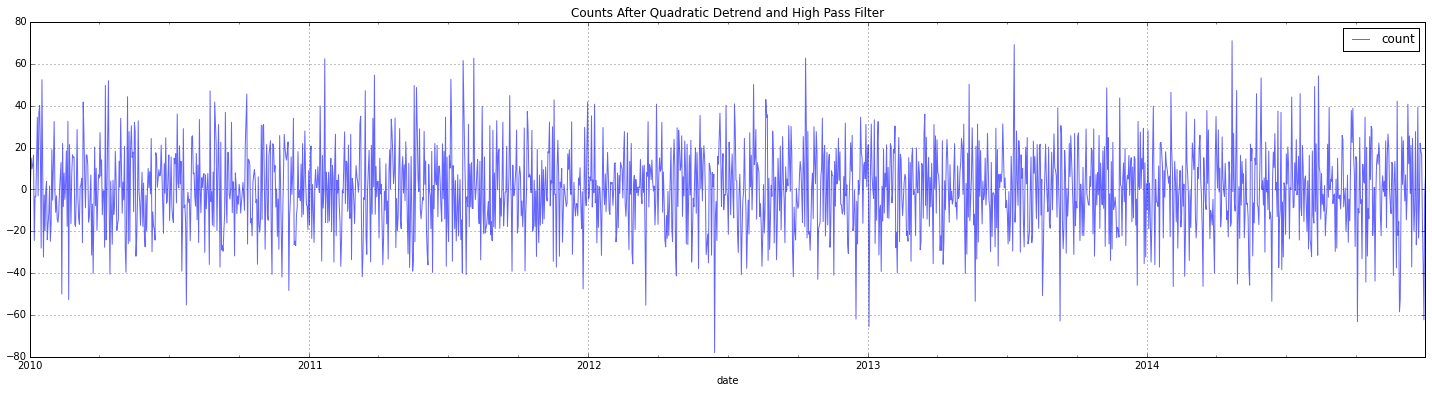

In [362]:
frq = 1 / 56.9 # from FFT output above
out = sigtools.hi_pass_filter(det_curve, frq, 1.0, 3)

dff = pd.DataFrame({'count':out}, index=df.index)
dff.plot(title="Counts After Quadratic Detrend and High Pass Filter", grid=True, figsize=(25, 6), alpha=0.6)

# 'Group By' for  Basic Analysis

Grouping and aggregating is a simple and powerful way to gain insights into data sets. For large data, or even medium large, I use a SQL database.
For small data like this, Pandas is perfect.

If we did this analysis before the detrending, then we'd see a periodic characteristic.

## Tangent into statistical time series analysis
### Group by Day: Global day trend averaging over the 5 years of 12 months = 60 data points


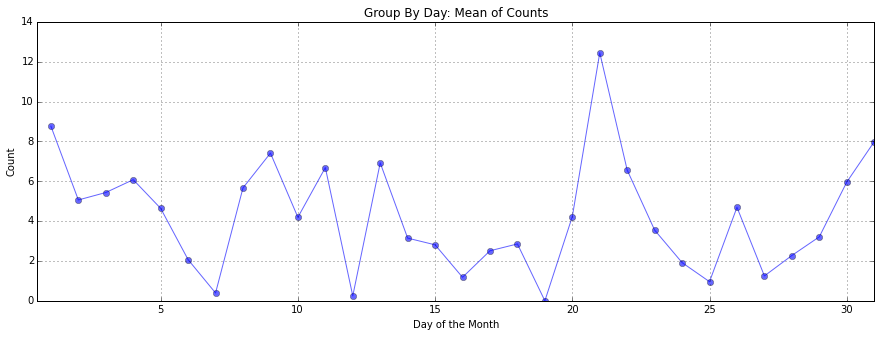

In [363]:
grp = dff.groupby(dff.index.map(lambda x:x.day)) #numerical day of the month, not DOTW
X = grp.mean()['count']
X -= X.min()

# decided to not use Pandas plot method b/c I wanted the -o style of lines
plt.figure(figsize=(15, 5))
plt.plot(X.index, X, '-o', alpha=0.6);

plt.title("Group By Day: Mean of Counts")
plt.xlabel("Day of the Month")
plt.ylabel("Count")

plt.xlim(0.5, 31)
plt.grid()

### Significance
The density estimate below suggests that the max count on the 21st day is significant.

Max count from density plot:    12.44
Mean count over days:            3.83
Rememebr I added some extra points to make the graph pretty


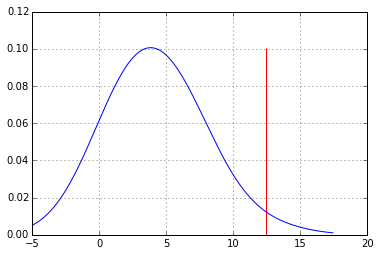

In [364]:
from scipy.stats import gaussian_kde

N = X.shape[0]
MIN = X.min() - 5
MAX = X.max() + 5
grid = np.linspace(MIN, MAX, 1000)

kde = gaussian_kde(X, bw_method=1.0)
out = kde.evaluate(grid)

plt.plot(grid, out)
plt.grid()

max_cnt_ind = X.argmax()
cnt_max = X[max_cnt_ind]

ht = out.max()
plt.vlines(cnt_max, 0, ht, 'r')

max_ind = out.argmax()
max_ = grid[max_ind]

print "Max count from density plot:    %.2f" % cnt_max
print "Mean count over days:            %.2f" % grid[max_ind]
print "Rememebr I added some extra points to make the graph pretty"

## Bootstrap for significance

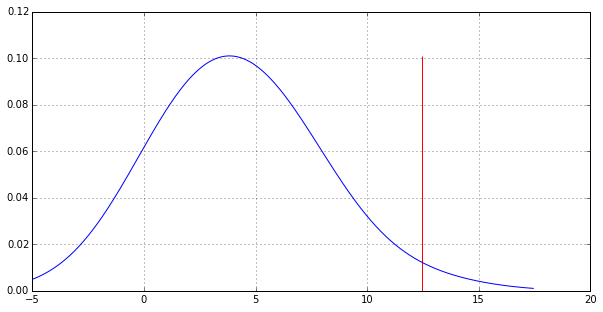

In [365]:
m = 2000
cnt = []

for i in range(m):
    sample = X.sample(n=N, replace=True)
    cnt.extend(sample)

cnt = np.array(cnt)

kde = gaussian_kde(cnt, bw_method=1.0)
out = kde.evaluate(grid)

plt.figure(figsize=(10, 5))
plt.plot(grid, out)

max_ind = cnt.argmax()
cnt_max = cnt[max_ind]
ht = out.max()

plt.vlines(cnt_max, 0, ht, 'r')
plt.grid()

#Back to Complete Data Set
## Kernel Density Estimate
http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html#scipy.stats.gaussian_kde

Sometime it makes sense to fit the data to a distribution and rely upon the distribution for the parameters like a mean and variance.

Let's assume that's a great thing to do here.

In [366]:
# undo the centering that occures fromt he previous procesing
count = dff['count'] - dff['count'].min()

def comp_kde(data):
    N = data.shape[0]
    min_ = data.min() - 10
    max_ = data.max()+10
    grid = np.linspace(min_, max_, 1000)
    
    kde = gaussian_kde(data, bw_method=None)
    out = kde.evaluate(grid)
    
    return out, grid

Mean of distribution: 79.18


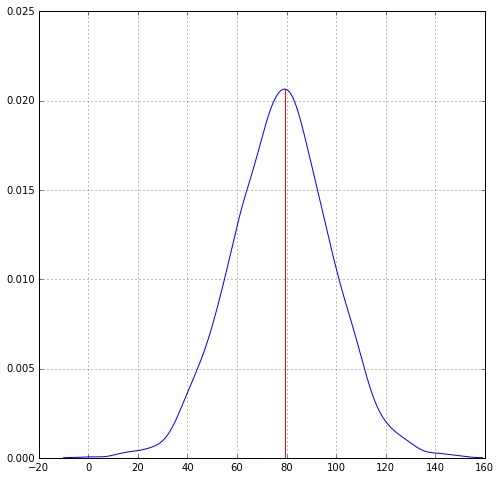

In [367]:
FIT, grid = comp_kde(count)
plt.figure(figsize=(8, 8))
plt.plot(grid, FIT)

max_ind = FIT.argmax()
MU_ = grid[max_ind]

ht = FIT.max()
plt.vlines(MU_, 0, ht, 'r')
plt.grid()

print "Mean of distribution: %.2f" % MU_

## Gaussian Fit

In [368]:
from scipy.optimize import curve_fit

def gauss(x, *p):
    A, mu, sig = p
    gau = A * np.exp(-(x-mu)**2 / (2 * sig)**2)
    return gau

Amplitude:0.019963  mean:78.152289   std:14.030888


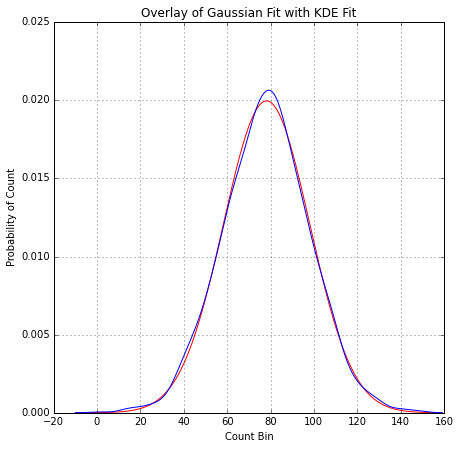

In [369]:
# fit the KDE to a Gaussian
coeff, var_matrix = curve_fit(gauss, grid, FIT, p0=[0.02, 70.0, 14.0])
print "Amplitude:%f  mean:%f   std:%f" %(coeff[0], coeff[1], coeff[2])
fit_gau = gauss(grid, *coeff)

plt.figure(figsize=(7, 7))
plt.plot(grid, fit_gau, 'r');
plt.plot(grid, FIT)

plt.grid()
plt.title("Overlay of Gaussian Fit with KDE Fit")
plt.xlabel("Count Bin")
plt.ylabel("Probability of Count")